In [81]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm

from itertools import permutations
import itertools
import sys

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Dark2")

In [82]:
def get_border(posteriors):
    if posteriors.ndim == 2:
        p = posteriors.shape[0]
        posteriors_p = posteriors.reshape((p,p))
    else:
        p = int(np.sqrt(len(posteriors)))
        posteriors_p = posteriors

    lit_up = np.zeros((p,p))
    current_value_horiz = posteriors_p[0, 0]
    current_value_vert = posteriors_p[0,0]
    for i in range(p):
        for j in range(p):
            if posteriors_p[i, j] != current_value_horiz:
                lit_up[i,j] += 1
                current_value_horiz = posteriors_p[i, j]
            else:
                lit_up[i, j] += 0

            if posteriors_p[j, i] != current_value_vert:
                lit_up[j,i] += 1
                current_value_vert = posteriors_p[j,i]
            else:
                lit_up[j,i] += 0

    lit_up_straight = lit_up.reshape(p**2)

    colors_ = []
    for i in range(p**2):
        if lit_up_straight[i] == 0:
            colors_.append(ax.get_facecolor())
        else:
            colors_.append('black')

    idx = np.array([i for i in range(p**2) if colors_[i] == 'black'])
    not_idx = np.array([i for i in range(p**2) if i not in idx])

    background= len(not_idx)*[ax.get_facecolor()]
    border= len(idx)*['black']
    
    return idx

In [83]:
np.warnings.filterwarnings('ignore')

"""
This file contains code for conditional entropy forests. 
Adapted from https://github.com/rguo123/conditional_entropy_forests/blob/master/code/algorithm.py
"""

def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_3d_rotation(acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    q = np.random.normal(0,1,4)
    q = q / np.sqrt(np.sum(q**2))
    
    R = np.array([
        [1 -2*(q[2]**2+q[3]**2), 2*(q[1]*q[2]-q[3]*q[0]), 2*(q[1]*q[3]+q[2]*q[0])],
        [2*(q[1]*q[2]+q[3]*q[0]), 1-2*(q[1]**2+q[3]**2), 2*(q[2]*q[3]-q[1]*q[0])],
        [2*(q[1]*q[3] - q[2]*q[0]), 2*(q[2]*q[3]+q[1]*q[0]), 1-2*(q[1]**2+q[2]**2)]
    ])
    return R

def finite_sample_correction(class_probs, row_sums):
    
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
    return class_probs

def build_model(X, y, n_estimators=200, max_samples=.32,
                                            bootstrap=True,
                                            depth=30,
                                            min_samples_leaf=1):
    if X.ndim == 1:
        raise ValueError('1d data will cause headaches down the road')
        
    max_features = int(np.ceil(np.sqrt(X.shape[1])))
        
    model=BaggingClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                                     max_features = max_features),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              bootstrap=bootstrap)
    
    model.fit(X, y)
    return model

def get_leaves(estimator):
    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
            
    return np.array(leaf_ids)

def estimate_posteriors(model, train, y, test, in_task=True, subsample=0, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = train.shape
    m, d_ = test.shape
    
    if d != d_:
        raise ValueError("train and test data in different dimensions")
    
    class_counts = np.zeros((m, model.n_classes_))
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
            # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
        else:
            if subsample:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
            else:
                prob_indices = range(n)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)
    
        # posteriors as a list
        class_probs.tolist()
        
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)
    
    return probs

def predict(a):
    return np.argmax(a, axis = 1)

def permutation(predict1, predict2, force=False):
    """
    how to use:
    
    this function returns the permutation i.e. \pi: [K] -> [K] that maximizes
    the number of matched predictions
    
    to use the permutation for posteriors for point i (posterior_i), say, simply use
    posterior_i[permutation]
    
    """
    unique_1 = np.unique(predict1)
    unique_1_new = np.arange(len(unique_1))
    
    unique_2 = np.unique(predict2)
    unique_2_new = np.arange(len(unique_2))
    
    if force:
        for i, u in enumerate(unique_1_new):
            if u not in unique_2_new:
                unique_2_new = np.concatenate((unique_2_new, [u]))
        
        for i, u in enumerate(unique_2_new):
            if u not in unique_1_new:
                unique_1_new = np.concatenate((unique_1_new, [u]))
    else:
        if set(unique_1) != set(unique_2):
            raise ValueError("predictions must be on the same set of labels")
        
    K = len(unique_1_new)
    
    max_sum = 0
    max_perm = unique_2_new
    for i, perm in enumerate(permutations(unique_2_new)):
        perm = np.array(list(perm))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for k in range(K):
            temp_predict2[np.where(predict2 == unique_2_new[k])[0]] = perm[k]
           
        temp_sum = np.sum(predict1 == temp_predict2)
        if temp_sum > max_sum:
            max_sum = temp_sum
            max_perm = perm
            
    return max_perm
            
def estimate_alpha(predict1, predict2, permutation=None):
    if permutation is None:
        return 2* (np.sum(predict1 == predict2) / len(predict1) - 0.5)
    else:
        unique = np.unique(predict2)
        unique_temp = np.unique(predict1)
        if len(unique) != len(unique_temp):
            unique = np.concatenate((unique, range(len(unique), len(unique) + len(unique_temp) - len(unique_temp))))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for i, k in enumerate(unique):
            print(np.where(predict2 == k)[0])
            print(permutation[i])
            temp_predict2[np.where(predict2 == k)[0]] = permutation[i]
            
        return 2 * (np.sum(predict1 == temp_predict2) / len(predict1) - 0.5)
    
def generate_sample(n, pi, conditional_0, params0, conditional_1, params1, d = 2, acorn=None):
    if acorn is None:
        acorn = np.random.seed(10**6)
    np.random.seed(acorn)
    
    n0 = int(np.random.binomial(n, pi))
    n1 = n - n0
    ns = [n0, n1]
    
    X0 = conditional_0(*params0, size=(n0, d))
    
    X1 = conditional_1(*params1, size=(n1, d))
    
    labels = np.concatenate([i*np.ones(ns[i]) for i in range(len(ns))]).astype(int)
    
    return [np.concatenate((X0, X1), axis = 0), labels]

def generate_parity(n, d=2, invert_labels=False,acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-1, 1, size=(n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if invert_labels:
        Y = -1 * (Y - 1)
    
    return X, Y.astype(int)

def parity_experiment(nx, nz, d, m, n_algos=6):
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)
    
    temp_predictions = [[] for __ in range(n_algos)]
    
    # Sum
    Z, labelsZ = generate_parity(nz + nx, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)
    
    model_best = build_model(Z, labelsZ, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best=estimate_posteriors(model_best, Z, labelsZ, testZ, in_task=True)
    predictions_best=predict(posteriors_best)
    
    errors[-1] = 1 - np.sum(test_labelsZ == predictions_best)/m

    # Source task
    X, labelsX = generate_parity(nx, d)
    testX, test_labelsX = generate_parity(m, d)

    
    # Target task
    Z, labelsZ = generate_parity(nz, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)


    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=1-0.32)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=1-0.32)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    # 
    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[1] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
    errors[2] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m
    
    

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[4] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m

    return errors

def get_border(posteriors):
    if posteriors.ndim == 2:
        p = posteriors.shape[0]
        posteriors_p = posteriors.reshape((p,p))
    else:
        p = int(np.sqrt(len(posteriors)))
        posteriors_p = posteriors.reshape((p,p))

    lit_up = np.zeros((p,p))
    current_value_horiz = posteriors_p[0, 0]
    current_value_vert = posteriors_p[0,0]
    for i in range(p):
        for j in range(p):
            if posteriors_p[i, j] != current_value_horiz:
                lit_up[i,j] += 1
                current_value_horiz = posteriors_p[i, j]
            else:
                lit_up[i, j] += 0

            if posteriors_p[j, i] != current_value_vert:
                lit_up[j,i] += 1
                current_value_vert = posteriors_p[j,i]
            else:
                lit_up[j,i] += 0

    lit_up_straight = lit_up.reshape(p**2)

    colors_ = []
    for i in range(p**2):
        if lit_up_straight[i] == 0:
            colors_.append(ax.get_facecolor())
        else:
            colors_.append('black')

    idx = np.array([i for i in range(p**2) if colors_[i] == 'black'])
    not_idx = np.array([i for i in range(p**2) if i not in idx])

    background= len(not_idx)*[ax.get_facecolor()]
    border= len(idx)*['black']
    
    return idx

In [5]:
def jovo_experiment(nx, nz, d, dist_x=generate_parity, dist_z=generate_parity, theta=0, m=100, target="Z", subsample = 0.32, n_algos=6, return_posteriors = False):
    if target == "Z":
        invert_z = True
        invert_x = False
    else:
        invert_z = False
        invert_x = True
        
#     Tx = int(np.floor(np.sqrt(nx)))
#     Tz = int(np.floor(np.sqrt(nz)))

    Tx = 1
    Tz = 1
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)

    # Source task
    X, labelsX = dist_x(nx, d, invert_labels=invert_x)
    testX, test_labelsX = dist_x(m, d, invert_labels=invert_x)
    
    # Target task
    Z, labelsZ = dist_z(nz, d, invert_labels=invert_z)
    testZ, test_labelsZ = dist_z(m, d, invert_labels=invert_z)
    
    if len(X[0, :]) == 2:
        R = generate_2d_rotation(theta)
    else:
        R = generate_3d_rotation()
        
    Z = Z @ R
    testZ = testZ @ R

    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=subsample)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=subsample)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
    errors[1] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
    errors[4] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[2] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    if return_posteriors:
        mesh_ =np.array(list(itertools.product(np.arange(-4, 4+0.05, step=0.05), np.arange(-4, 4+0.05, step=0.05))))
        
        posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, mesh_, in_task=True)
        posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, mesh_, in_task=False, subsample=subsample)

        posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, mesh_, in_task=False, subsample=subsample)
        posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, mesh_, in_task=True)
                    
        return posteriors_structX_estX, posteriors_structZ_estX, posteriors_structZ_estZ, posteriors_structX_estZ
    else:
        return errors

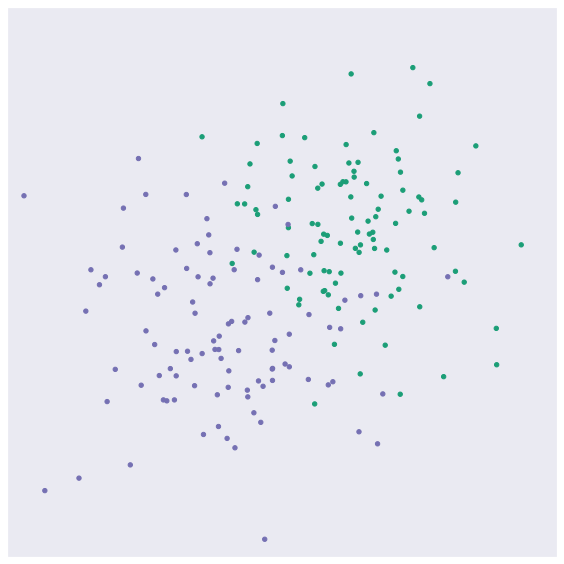

In [80]:
sns.set()
np.random.seed(1)

nx = 100
nz = 100

mu1 = [1, 1]
mu2 = [-1, -1]

c = 1.75
cov = c*np.eye(2)

X = np.random.multivariate_normal(mu1, cov, nx)
yX = nx*[colors[0]]

Z = np.random.multivariate_normal(mu2, cov, nz)
yZ = nz*[colors[2]]

lim = 5
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(X[:, 0], X[:, 1], s=75, marker='.', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], s=75, marker='.', c=yZ)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_linear_problem1.png', dpi=500)

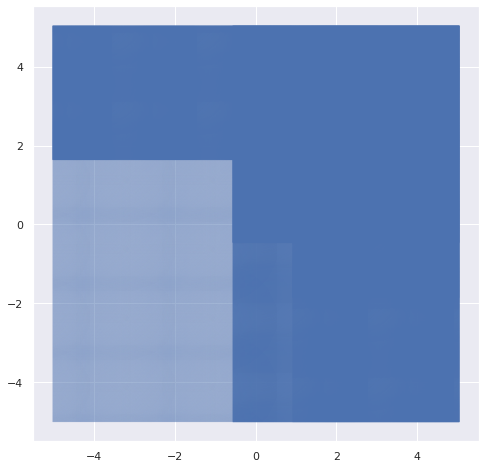

In [45]:
import itertools
np.random.seed(2)
xx = np.arange(-lim, lim+0.05, step=0.025)
yy = np.arange(-lim, lim+0.05, step=0.025)
p = len(xx)

mesh_ = np.array(list(itertools.product(xx, yy)))
mesh_unraveled = mesh_.reshape((2*p**2))

yX_ = nx*[0]
yZ_ = nz*[1]

X_all = np.concatenate((X, Z), axis=0)
y_all = np.concatenate((yX_,yZ_), axis=0)

F = build_model(X_all, y_all, n_estimators=1)

prob_indices = _generate_unsampled_indices(F[0].random_state, nx + nz)

X_inds = np.array([i for i in range(nx) if i in prob_indices])
Z_inds = np.array([nx - i for i in range(nx,nx+nz) if i in prob_indices])

X_ninds = np.array([i for i in range(nx) if i not in X_inds])
Z_ninds = np.array([i for i in range(nz) if i not in Z_inds])

# X_inds2 = np.array([i for i in range(nx) if i in prob_indices2])
# Z_inds2 = np.array([nx - i for i in range(nx,nx+nz) if i in prob_indices2])

# X_ninds2 = np.array([i for i in range(nx) if i not in X_inds2])
# Z_ninds2 = np.array([i for i in range(nz) if i not in Z_inds2])
                
posteriors = estimate_posteriors(F, X_all, y_all, mesh_)[:, 0]
# posteriors2 = estimate_posteriors(F2,X_all, y_all, mesh_)[:,0]

# avg_posteriors = (posteriors + posteriors2) / 2
posteriors_p = posteriors.reshape((p,p))

# posteriors_p2 = posteriors2.reshape((p,p))

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(mesh_[:, 0], mesh_[:, 1], posteriors)

## Decision Tree

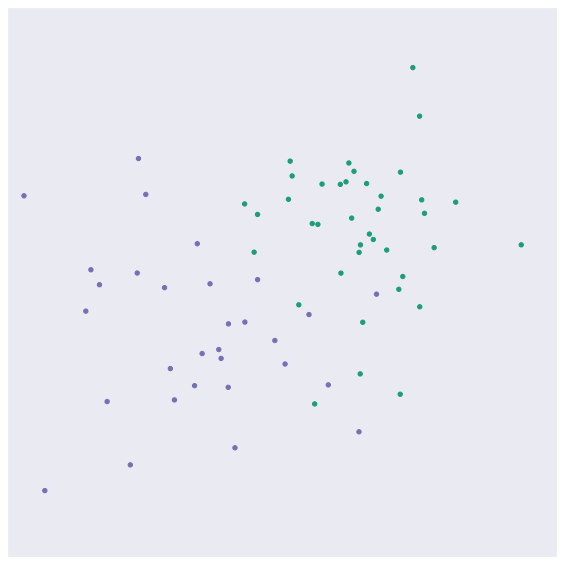

In [9]:
sns.set()

# plt.style.use('seaborn-white')
np.random.seed(1)

yX_ = nx*[0]
yZ_ = nz*[1]

fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[X_inds, 0], X[X_inds, 1], s=75, marker='.', c=yX[:len(X_inds)])
ax.scatter(Z[Z_inds, 0], Z[Z_inds, 1], s=75, marker='.', c=yZ[:len(Z_inds)])

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_decisiontree_transformer_data.png',dpi=500)

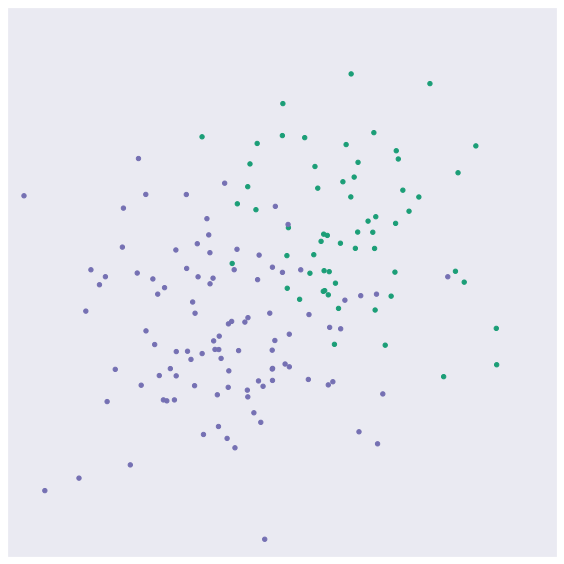

In [10]:
np.random.seed(1)

yX_ = nx*[0]
yZ_ = nz*[1]

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.scatter(X[X_ninds,0], X[X_ninds,1], c=yX[:len(X_ninds)], s=75, marker='.')
ax.scatter(Z[Z_ninds, 0], Z[Z_ninds, 1], c=yZ[:len(Z_ninds)], s=75, marker='.')
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_decisiontree_decider_data.png',dpi=500)

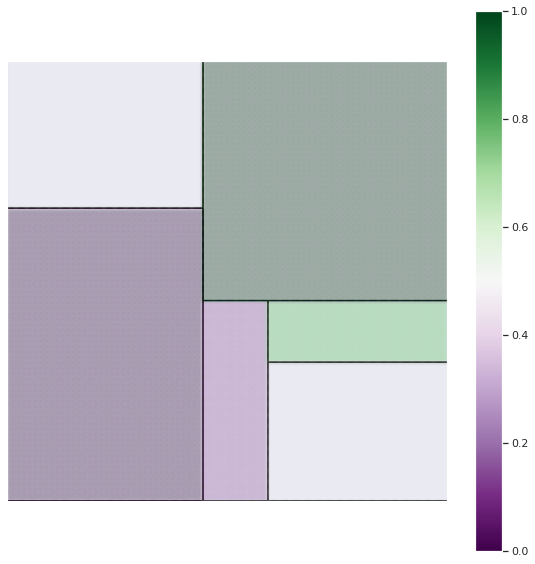

In [13]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

idx = get_border(posteriors)
border = len(idx)*['k']

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriors, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('cml_decisiontree_learneddecider.png',dpi=500)

In [ ]:
# decider for task J

In [ ]:
# combined decider for task 1

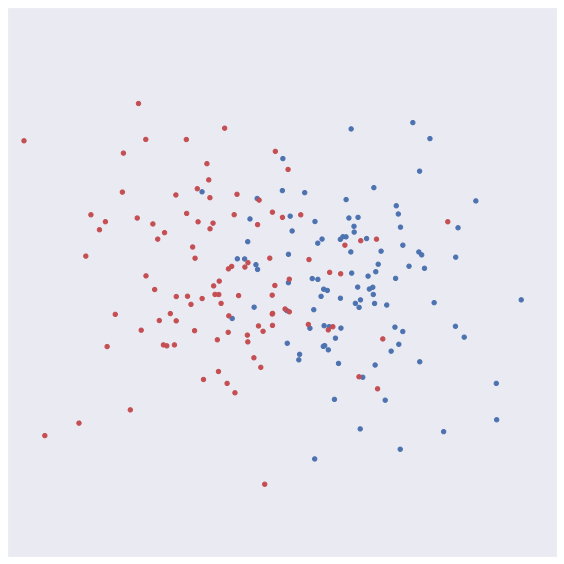

In [38]:
sns.set()
np.random.seed(1)

nx = 100
nz = 100

mu1 = [1, 0]
mu2 = [-1, 0]

c = 1.75
cov = c*np.eye(2)

A = np.random.multivariate_normal(mu1, cov, nx)
yA = nx*['b']

B = np.random.multivariate_normal(mu2, cov, nz)
yB = nz*['r']

lim = 5
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(A[:, 0], A[:, 1], s=75, marker='.', c=yA)
ax.scatter(B[:, 0], B[:, 1], s=75, marker='.', c=yB)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_linear_problem_dataset2.png', dpi=500)

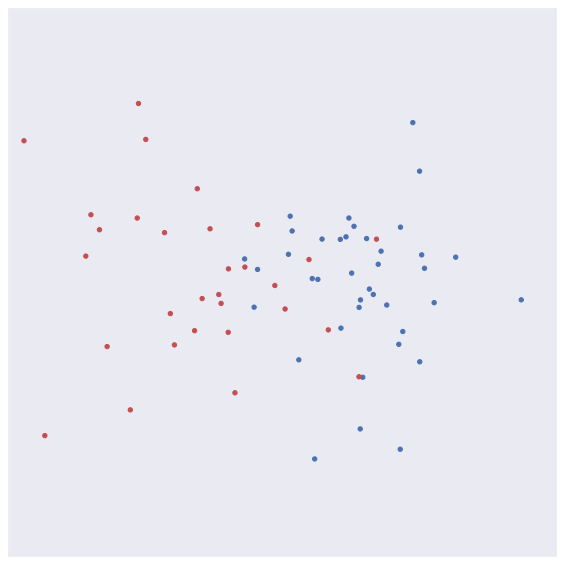

In [39]:
sns.set()
np.random.seed(1)

nx = 100
nz = 100

mu1 = [1, 0]
mu2 = [-1, 0]

c = 1.75
cov = c*np.eye(2)

# A = np.random.multivariate_normal(mu1, cov, nx)
# yA = nx*[colors[1]]

# B = np.random.multivariate_normal(mu2, cov, nz)
# yB = nz*[colors[7]]

lim = 5
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(A[X_inds, 0], A[X_inds, 1], s=75, marker='.', c=yA[:len(X_inds)])
ax.scatter(B[Z_inds, 0], B[Z_inds, 1], s=75, marker='.', c=yB[:len(Z_inds)])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_linear_transformer_dataset2.png', dpi=500)

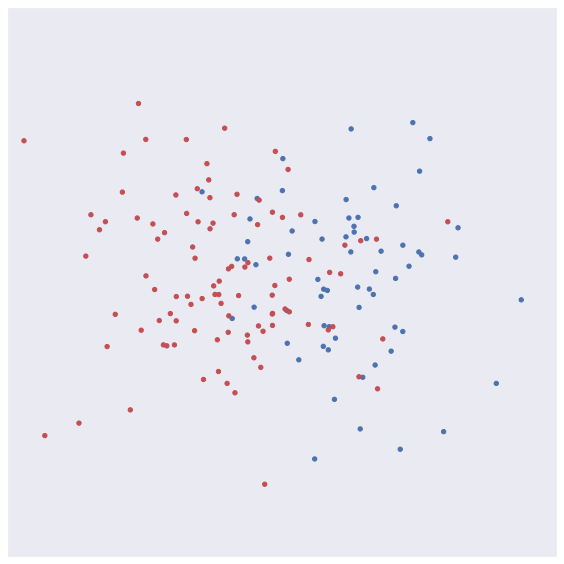

In [40]:
sns.set()
np.random.seed(1)

nx = 100
nz = 100

mu1 = [1, 0]
mu2 = [-1, 0]

c = 1.75
cov = c*np.eye(2)

# A = np.random.multivariate_normal(mu1, cov, nx)
# yA = nx*[colors[1]]

# B = np.random.multivariate_normal(mu2, cov, nz)
# yB = nz*[colors[7]]

lim = 5
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(A[A_ninds, 0], A[A_ninds, 1], s=75, marker='.', c=yA[:len(A_ninds)])
ax.scatter(B[B_ninds, 0], B[B_ninds, 1], s=75, marker='.', c=yB[:len(B_ninds)])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_linear_decider_dataset2.png', dpi=500)

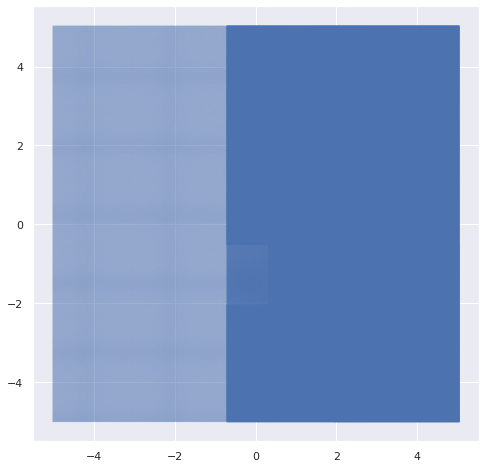

In [65]:
import itertools
np.random.seed(10)
xx = np.arange(-lim, lim+0.05, step=0.025)
yy = np.arange(-lim, lim+0.05, step=0.025)
p = len(xx)

mesh_ = np.array(list(itertools.product(xx, yy)))
mesh_unraveled = mesh_.reshape((2*p**2))

yA_ = nx*[0]
yB_ = nz*[1]

A_all = np.concatenate((A, B), axis=0)
B_all = np.concatenate((yA_,yB_), axis=0)

FA = build_model(A_all, B_all, n_estimators=1)

prob_indicesA = _generate_unsampled_indices(FA[0].random_state, nx + nz)

A_inds = np.array([i for i in range(nx) if i in prob_indicesA])
B_inds = np.array([nx - i for i in range(nx,nx+nz) if i in prob_indicesA])

A_ninds = np.array([i for i in range(nx) if i not in A_inds])
B_ninds = np.array([i for i in range(nz) if i not in B_inds])
                
posteriorsA = estimate_posteriors(FA, A_all, B_all, mesh_)[:, 0]

posteriors_pA = posteriorsA.reshape((p,p))

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(mesh_[:, 0], mesh_[:, 1], posteriorsA)

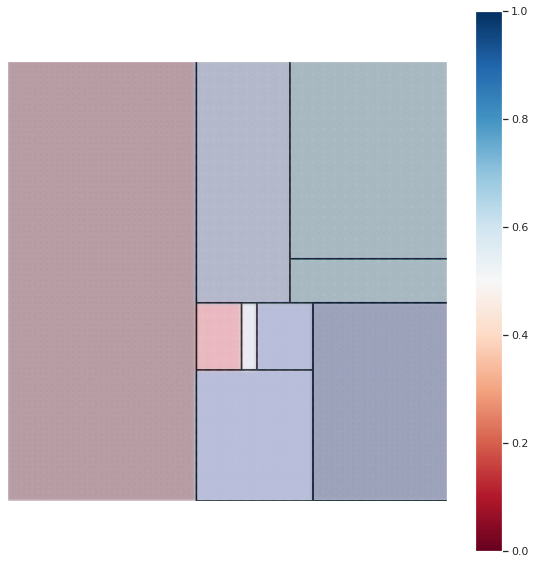

In [75]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

posteriors1A = estimate_posteriors(FA, X_all, y_all, mesh_, in_task=False)[:, 0]

idx1A = get_border(posteriorsA + posteriors1A)
border1A = len(idx1A)*['k']

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx1A, 0], mesh_[idx1A, 1], c=border1A, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriorsA, alpha=0.0075, cmap='RdBu')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("RdBu")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('cml_decisiontree_learneddecider2.png',dpi=500)

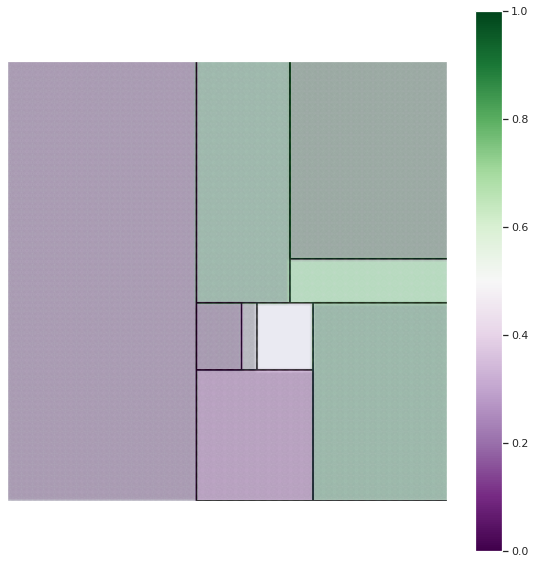

In [72]:
# out of task, decider for task 1

fig, ax = plt.subplots(1,1,figsize=(8,8))

idx1A = get_border(posteriorsA + posteriors1A)
border1A = len(idx1A)*['k']

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx1A, 0], mesh_[idx1A, 1], c=border1A, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriors1A, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('cml_outoftask_decidertask1.png',dpi=500)

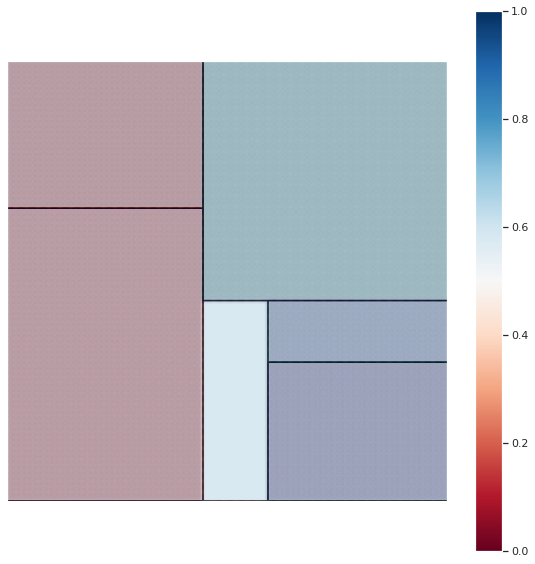

In [77]:
# out of task, decider for task 2


fig, ax = plt.subplots(1,1,figsize=(8,8))

posteriorsA1 = estimate_posteriors(F, A_all, B_all, mesh_, in_task=False)[:, 0]

idxA1 = get_border(posteriors + posteriorsA1)
borderA1 = len(idxA1)*['k']

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idxA1, 0], mesh_[idxA1, 1], c=borderA1, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriorsA1, alpha=0.0075, cmap='RdBu')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("RdBu")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('cml_outoftask_decidertask2.png',dpi=500)

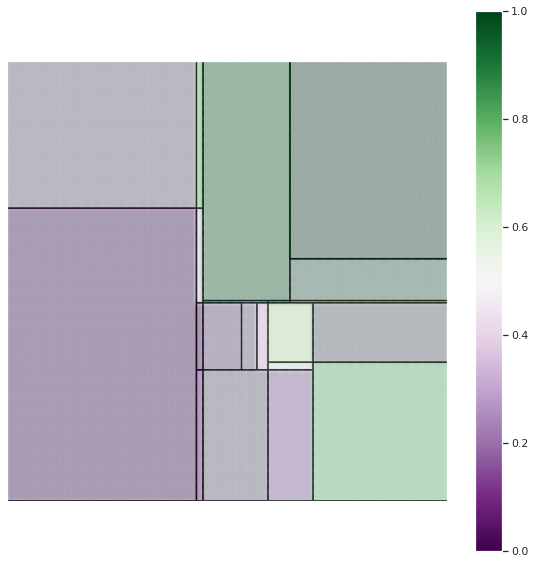

In [79]:
# lifelong decider task 1
fig, ax = plt.subplots(1,1,figsize=(8,8))

# idx1A = get_border(posteriorsA + posteriors1A)
# border1A = len(idx1A)*['k']

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx1A, 0], mesh_[idx1A, 1], c=border1A, s=.5)
ax.scatter(mesh_[idxA1, 0], mesh_[idxA1, 1], c=borderA1, s=.5)

ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=(posteriors1A + posteriors)/2, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('lifelong_decider_task1.png',dpi=500)

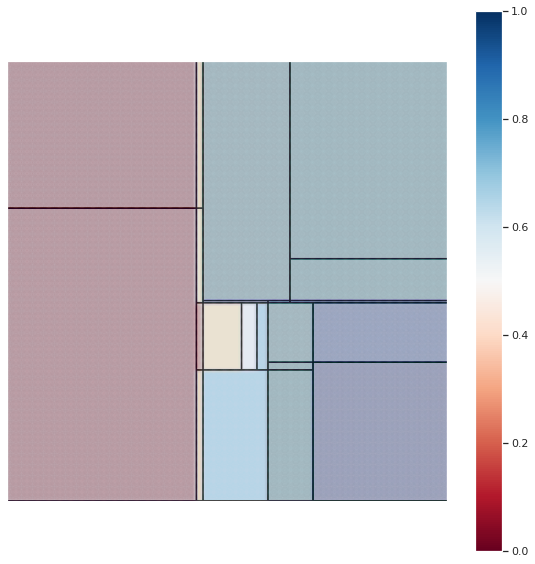

In [78]:
# lifelong decider task 2
fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(mesh_[idx1A, 0], mesh_[idx1A, 1], c=border1A, s=.5)
ax.scatter(mesh_[idxA1, 0], mesh_[idxA1, 1], c=borderA1, s=.5)

ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=(posteriorsA1 + posteriorsA)/2, alpha=0.0075, cmap='RdBu')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("RdBu")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('lifelong_decider_task2.png',dpi=500)

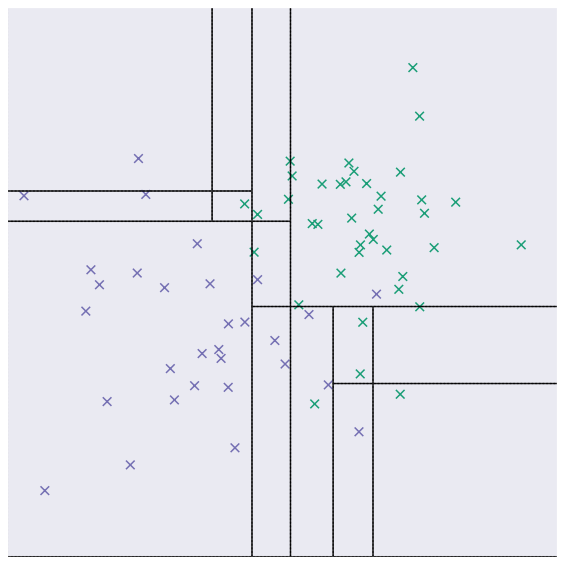

In [91]:
lit_up = np.zeros((p,p))
current_value_horiz = posteriors_p[0, 0]
current_value_vert = posteriors_p[0,0]
for i in range(p):
    for j in range(p):
        if posteriors_p[i, j] != current_value_horiz:
            lit_up[i,j] += 1
            current_value_horiz = posteriors_p[i, j]
        else:
            lit_up[i, j] += 0
            
        if posteriors_p[j, i] != current_value_vert:
            lit_up[j,i] += 1
            current_value_vert = posteriors_p[j,i]
        else:
            lit_up[j,i] += 0
            
lit_up_straight = lit_up.reshape(p**2)

colors_ = []
for i in range(p**2):
    if lit_up_straight[i] == 0:
        colors_.append(ax.get_facecolor())
    else:
        colors_.append('black')
        
idx = np.array([i for i in range(p**2) if colors_[i] == 'black'])
not_idx = np.array([i for i in range(p**2) if i not in idx])

background= len(not_idx)*[ax.get_facecolor()]
border= len(idx)*['black']

# plt.style.use('seaborn-white')
fig, ax = plt.subplots(1,1,figsize=(8,8))

# ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[X_inds,0], X[X_inds,1], c=yX[:len(X_inds)], s=75, marker='x')
ax.scatter(Z[Z_inds, 0], Z[Z_inds, 1], c=yZ[:len(Z_inds)], s=75, marker='x')

# ax.scatter(X[-X_inds,0], X[-X_inds,1], c=yX[:len(-X_inds)], alpha=0.25, s=75, marker='x')
# ax.scatter(Z[-Z_inds, 0], Z[-Z_inds, 1], c=yZ[:len(-Z_inds)], alpha=0.25, s=75, marker='.')



# ax.scatter(X_all[prob_indices, 0], X_all[prob_indices, 1], c=np.concatenate((yX, yZ))[prob_indices], s=50, marker=)
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border, s=.5)

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_decisiontree_transformed_transformerdata.png',dpi=500)

In [ ]:
borders = 

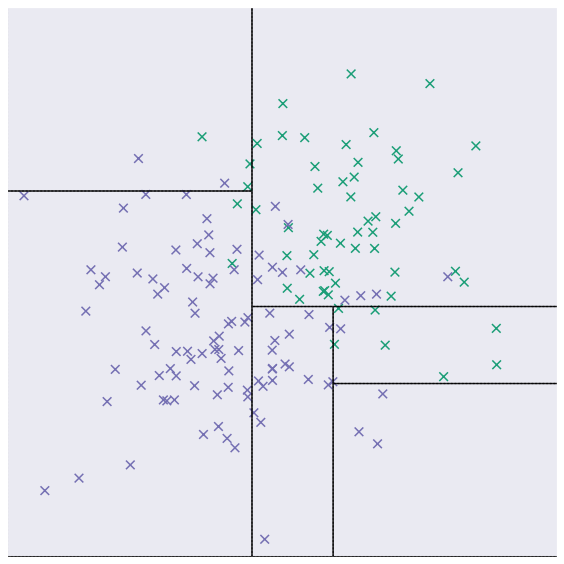

In [43]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(X[X_ninds,0], X[X_ninds,1], c=yX[:len(X_ninds)], s=75, marker='x')
ax.scatter(Z[Z_ninds, 0], Z[Z_ninds, 1], c=yZ[:len(Z_ninds)], s=75, marker='x')

ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border, s=.5)

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_decisiontree_transformed_deciderdata.png',dpi=500)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


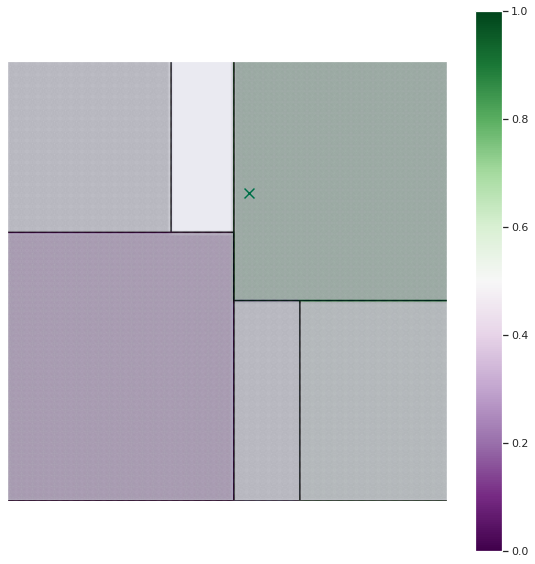

In [96]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

idx = get_border(posteriors)

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=len(idx)*['k'], s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriors, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

# plt.savefig('cml_decisiontree_labeled.png',dpi=500)

## Transfer Tree

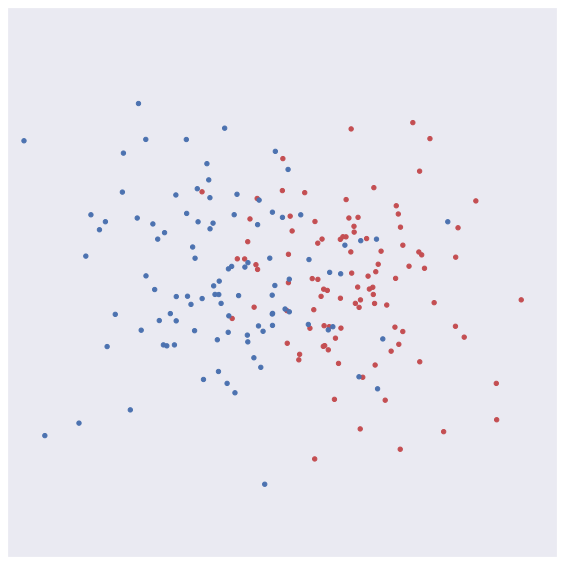

In [17]:
sns.set()
np.random.seed(1)

nx = 100
nz = 100

mu1 = [1, 0]
mu2 = [-1, 0]

c = 1.75
cov = c*np.eye(2)

A = np.random.multivariate_normal(mu1, cov, nx)
yA = nx*['r']

B = np.random.multivariate_normal(mu2, cov, nz)
yB = nz*['b']

lim = 5
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(A[:, 0], A[:, 1], s=75, marker='.', c=yA)
ax.scatter(B[:, 0], B[:, 1], s=75, marker='.', c=yB)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_linear_problem_dataset2.png', dpi=500)

In [22]:
np.random.seed(4)
xx = np.arange(-lim, lim+0.05, step=0.025)
yy = np.arange(-lim, lim+0.05, step=0.025)
p = len(xx)

mesh_ = np.array(list(itertools.product(xx, yy)))
mesh_unraveled = mesh_.reshape((2*p**2))

A_all = np.concatenate((A, B), axis=0)
B_all = np.concatenate((yA,yB), axis=0)

FA = build_model(X_all, y_all, n_estimators=1)
# F2 = build_model(X_all, y_all, n_estimators=1)

prob_indicesA = _generate_unsampled_indices(FA[0].random_state, nx + nz)
# prob_indices2 = _generate_unsampled_indices(F2[0].random_state, nx + nz)

A_inds = np.array([i for i in range(nx) if i in prob_indicesA])
B_inds = np.array([nx - i for i in range(nx,nx+nz) if i in prob_indicesA])

A_ninds = np.array([i for i in range(nx) if i not in A_inds])
B_ninds = np.array([i for i in range(nz) if i not in B_inds])

# X_inds2 = np.array([i for i in range(nx) if i in prob_indices2])
# Z_inds2 = np.array([nx - i for i in range(nx,nx+nz) if i in prob_indices2])

# X_ninds2 = np.array([i for i in range(nx) if i not in X_inds2])
# Z_ninds2 = np.array([i for i in range(nz) if i not in Z_inds2])
                
posteriorsA = estimate_posteriors(FA, X_all, y_all, mesh_)[:, 0]
# posteriors = estimate_posteriors(F,X_all, y_all, mesh_)[:,0]

# avg_posteriors = (posteriors + posteriors2) / 2
# posteriors_p = posteriors2.reshape((p,p))

# posteriors_p2 = posteriors2.reshape((p,p))

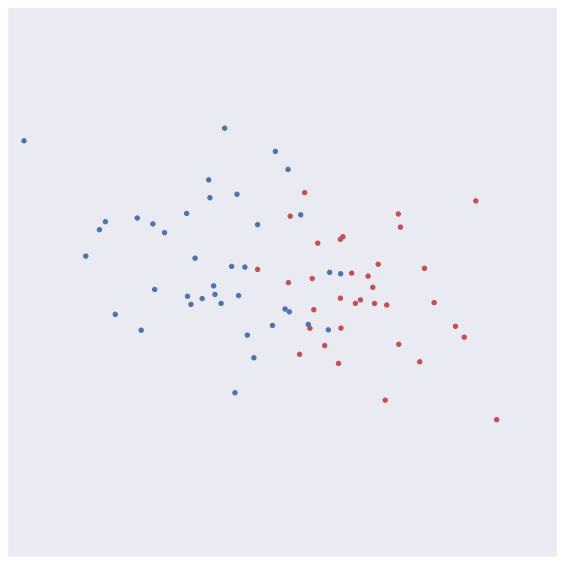

In [27]:
sns.set()
np.random.seed(1)

nx = 100
nz = 100

mu1 = [1, 0]
mu2 = [-1, 0]

c = 1.75
cov = c*np.eye(2)

A = np.random.multivariate_normal(mu1, cov, nx)
yA = nx*['r']

B = np.random.multivariate_normal(mu2, cov, nz)
yB = nz*['b']

lim = 5
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(A[A_inds, 0], A[A_inds, 1], s=75, marker='.', c=yA[:len(A_inds)])
ax.scatter(B[B_inds, 0], B[B_inds, 1], s=75, marker='.', c=yB[:len(B_inds)])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_linear_transformer_dataset2.png', dpi=500)

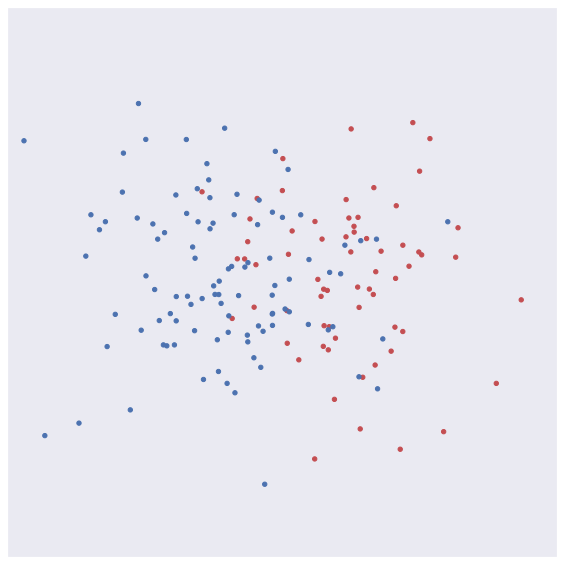

In [28]:
sns.set()
np.random.seed(1)

nx = 100
nz = 100

mu1 = [1, 0]
mu2 = [-1, 0]

c = 1.75
cov = c*np.eye(2)

lim = 5
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(A[A_ninds, 0], A[A_ninds, 1], s=75, marker='.', c=yA[:len(A_ninds)])
ax.scatter(B[B_ninds, 0], B[B_ninds, 1], s=75, marker='.', c=yB[:len(B_ninds)])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_linear_decider_dataset2.png', dpi=500)

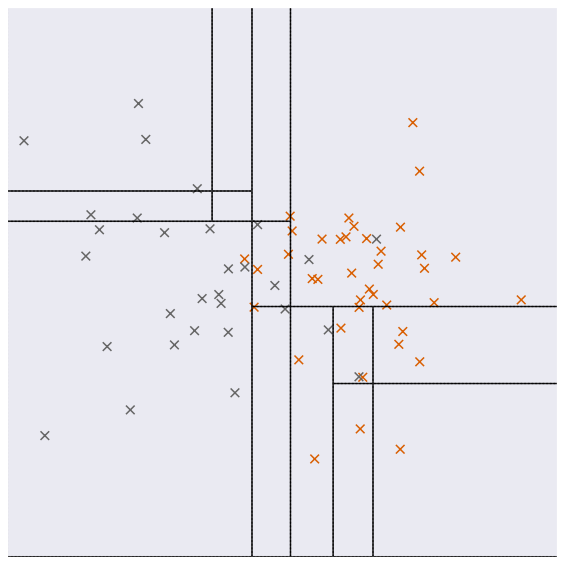

In [89]:
lit_up = np.zeros((p,p))
current_value_horiz = posteriors_p[0, 0]
current_value_vert = posteriors_p[0,0]
for i in range(p):
    for j in range(p):
        if posteriors_p[i, j] != current_value_horiz:
            lit_up[i,j] += 1
            current_value_horiz = posteriors_p[i, j]
        else:
            lit_up[i, j] += 0
            
        if posteriors_p[j, i] != current_value_vert:
            lit_up[j,i] += 1
            current_value_vert = posteriors_p[j,i]
        else:
            lit_up[j,i] += 0
            
lit_up_straight = lit_up.reshape(p**2)

colors_ = []
for i in range(p**2):
    if lit_up_straight[i] == 0:
        colors_.append(ax.get_facecolor())
    else:
        colors_.append('black')
        
idx = np.array([i for i in range(p**2) if colors_[i] == 'black'])
not_idx = np.array([i for i in range(p**2) if i not in idx])

background= len(not_idx)*[ax.get_facecolor()]
border2= len(idx)*['black']

# plt.style.use('seaborn-white')
fig, ax = plt.subplots(1,1,figsize=(8,8))

# ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(A[X_inds,0], A[X_inds,1], c=yA[:len(X_inds)], s=75, marker='x')
ax.scatter(B[Z_inds, 0], B[Z_inds, 1], c=yB[:len(Z_inds)], s=75, marker='x')

ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border2, s=.5)

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_decisiontree_transformed_transformerdata_dataset2.png',dpi=500)

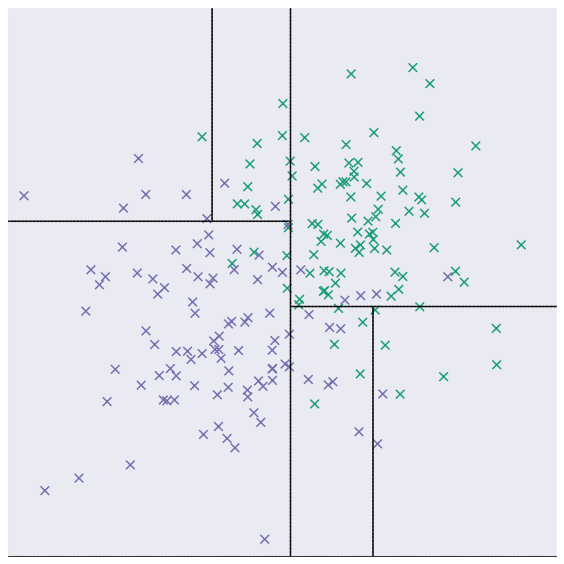

In [64]:
# plt.style.use('seaborn-white')
fig, ax = plt.subplots(1,1,figsize=(8,8))

# ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[:,0], X[:,1], c=yX, s=75, marker='x')
ax.scatter(Z[:, 0], Z[:, 1], c=yZ, s=75, marker='x')

ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border2, s=.5)

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_decisiontree_transformed_deciderdata_dataset2.png',dpi=500)

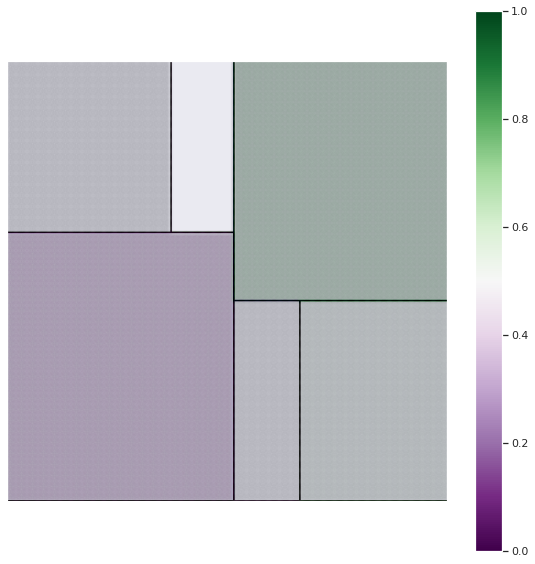

In [65]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border2, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriors2, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('cml_decisiontree_learneddecider_dataset2.png',dpi=500)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


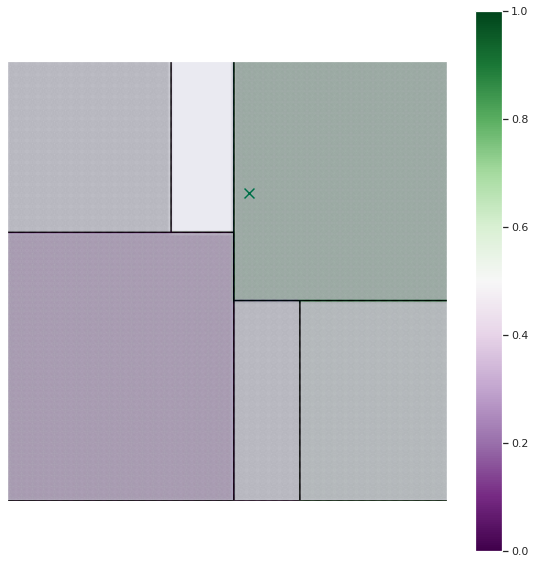

In [63]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriors, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('cml_decisiontree_labeled_dataset2.png',dpi=500)

## Lifelong Forest

In [ ]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border2, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=avg_posteriors, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('lifelong_learned_decider.png', dpi=500)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


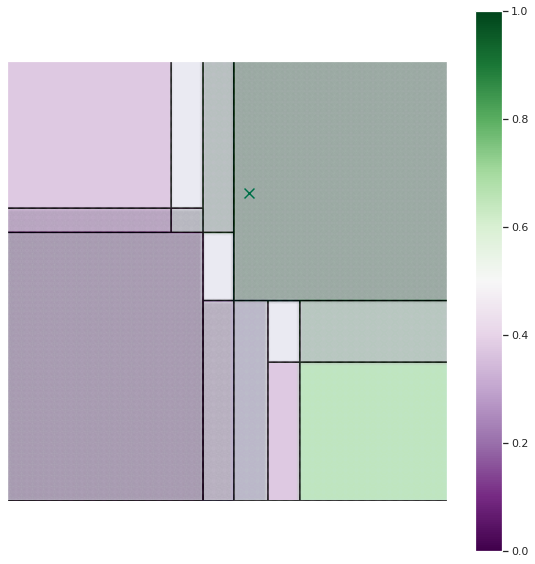

In [81]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(0.5, 2, s=100, c=colors[0], marker='x')
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border2, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=avg_posteriors, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)
plt.tight_layout()

plt.savefig('lifelong_labeled_point.png', dpi=500)

**Transfer Learning in the Transformer and Decider framework.**

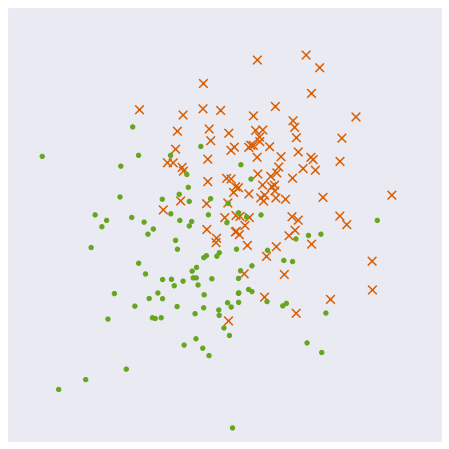

In [17]:
# Source Data
sns.set()
np.random.seed(1)

nx = 100
nz = 100

mu1 = [0.5, 1]
mu2 = [-0.5, -1]

c = 1.75
cov = c*np.eye(2)

X0 = np.random.multivariate_normal(mu1, cov, nx)
yX0 = nx*[colors[1]]

Z0 = np.random.multivariate_normal(mu2, cov, nz)
yZ0 = nz*[colors[4]]

lim = 5
fig, ax = plt.subplots(1,1, figsize=(8,8))
#ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(X0[:, 0], X0[:, 1], s=75, marker='x', c=yX0)
ax.scatter(Z0[:, 0], Z0[:, 1], s=75, marker='.', c=yZ0)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.savefig('tlsource_data.png', dpi=500)

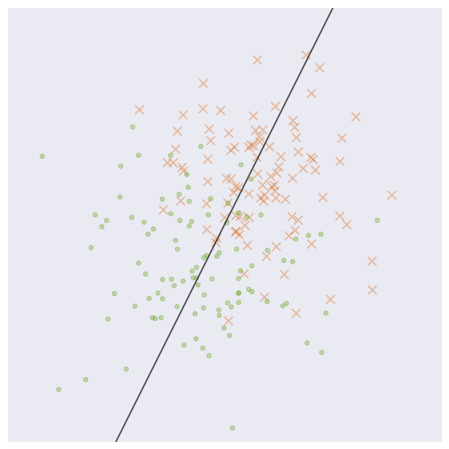

In [18]:
# lim = 4
fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(X0[:, 0], X0[:, 1], alpha=0.33, s=75, marker='x', c=yX0)
ax.scatter(Z0[:, 0], Z0[:, 1], alpha=0.33, s=75, marker='.', c=yZ0)
# ax.scatter(Z[0, 0], Z[0, 1], s=7.5, c=yZ[0])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.savefig('tlsource_rep.png', dpi=500)

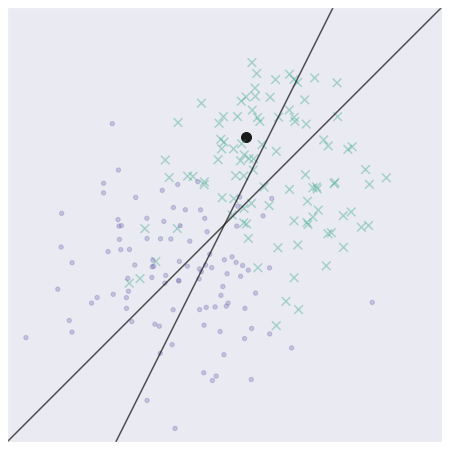

In [19]:
# Source and Target Representation on Target Space
# lim = 4
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')

mu1 = [1, 1]
mu2 = [-1, -1]

c = 1.75
cov = c*np.eye(2)

X = np.random.multivariate_normal(mu1, cov, nx)
yX = nx*[colors[0]]

Z = np.random.multivariate_normal(mu2, cov, nz)
yZ = nz*[colors[2]]
ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
# ax.scatter(Z[0, 0], Z[0, 1], s=7.5, c=yZ[0])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
# Source representation space.
ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.savefig('tlboth_reps.png', dpi=500)

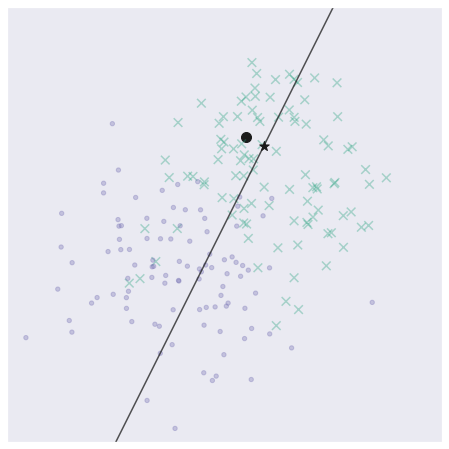

In [20]:
# Test point projected onto source representation
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
# Source representation space.
ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

line = np.array([1, 2])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)

ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

plt.savefig('tlsource_projected.png', dpi=500)

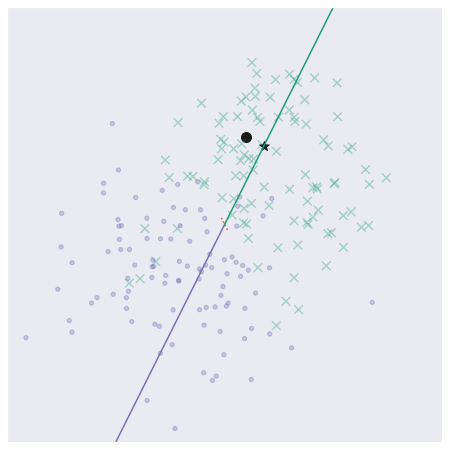

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-0.5*lim, 0 +0.025, step=0.025), np.arange(-lim, 0+0.05, step=0.05), c=colors[2], alpha=1)
ax.plot(np.arange(-0, 0.5*lim +0.025, step=0.025), np.arange(-0, lim+0.05, step=0.05), c=colors[0], alpha=1)
ax.plot(np.arange(-0.075, 0.1, step=0.0125), -np.arange(-0.15, 0.2, step=0.025), c=colors[1], ls=':')
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

line = np.array([1, 2])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

plt.savefig('tlsource_decider.png', dpi=500)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


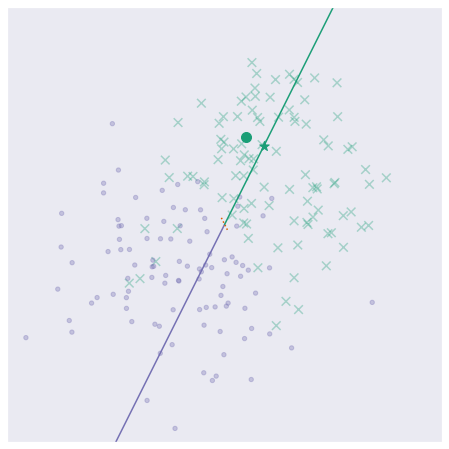

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c=colors[0], marker='o')

ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-0.5*lim, 0 +0.025, step=0.025), np.arange(-lim, 0+0.05, step=0.05), c=colors[2], alpha=1)
ax.plot(np.arange(-0, 0.5*lim +0.025, step=0.025), np.arange(-0, lim+0.05, step=0.05), c=colors[0], alpha=1)
ax.plot(np.arange(-0.075, 0.1, step=0.0125), -np.arange(-0.15, 0.2, step=0.025), c=colors[1], ls=':')
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

line = np.array([1, 2])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)

ax.scatter(proj[0], proj[1], s = 100, marker='*', c=colors[0])

plt.savefig('tlsource_classified.png', dpi=500)

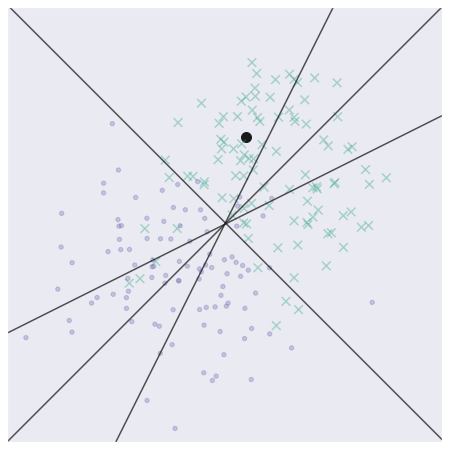

In [23]:
# Many possible representations
# lim = 4
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
# ax.scatter(Z[0, 0], Z[0, 1], s=7.5, c=yZ[0])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)

# Source representation space.
ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)

# Representation space 1.
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(lim+0.05, -lim, step=-0.05), c='k', alpha=0.75)

# Representation space 2.
ax.plot(np.arange(-lim, lim+0.05, step=0.05), np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), c='k', alpha=0.75)

# Representation space 3.
#ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)

ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.savefig('l2_reps.png', dpi=500)

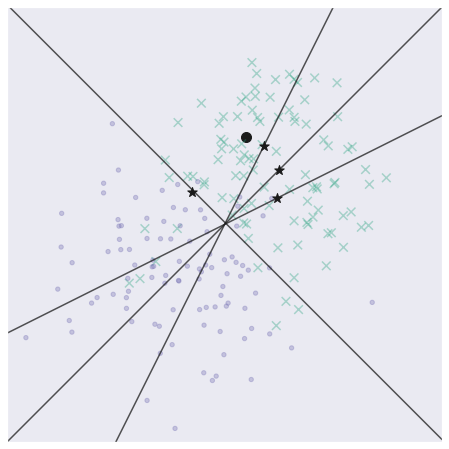

In [24]:
# Many possible representations - project on all of them.
# lim = 4
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
# ax.scatter(Z[0, 0], Z[0, 1], s=7.5, c=yZ[0])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
line = np.array([1, 1])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

# Source representation space.
ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
line = np.array([1, 2])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

# Representation space 1.
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(lim+0.05, -lim, step=-0.05), c='k', alpha=0.75)
line = np.array([-1, 1])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

# Representation space 2.
ax.plot(np.arange(-lim, lim+0.05, step=0.05), np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), c='k', alpha=0.75)
line = np.array([2, 1])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

# Representation space 3.
#ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)

ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.savefig('l2_projected.png', dpi=500)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


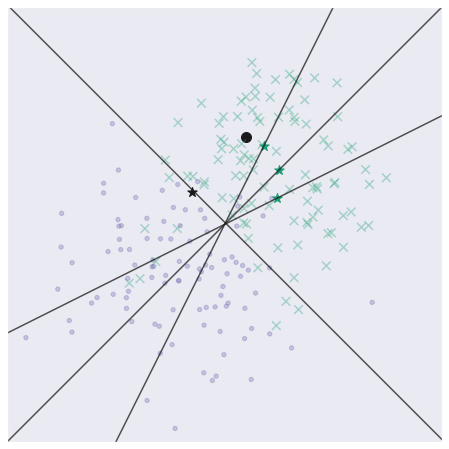

In [25]:
# Many possible representations - project on all of them.
# lim = 4
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
# ax.scatter(Z[0, 0], Z[0, 1], s=7.5, c=yZ[0])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
line = np.array([1, 1])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c=colors[0])

# Source representation space.
ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
line = np.array([1, 2])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c=colors[0])

# Representation space 1.
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(lim+0.05, -lim, step=-0.05), c='k', alpha=0.75)
line = np.array([-1, 1])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

# Representation space 2.
ax.plot(np.arange(-lim, lim+0.05, step=0.05), np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), c='k', alpha=0.75)
line = np.array([2, 1])
proj = (np.dot(np.array([0.5, 2]), line) * line) / np.dot(line, line)
ax.scatter(proj[0], proj[1], s = 100, marker='*', c=colors[0])

# Representation space 3.
#ax.plot(np.arange(-0.5*lim, 0.5*lim +0.025, step=0.025), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)

ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.savefig('l2_classifed.png', dpi=500)

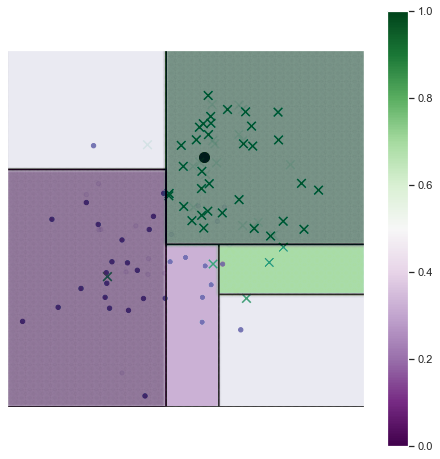

In [26]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[-X_inds,0], X[-X_inds,1], c=yX[:len(-X_inds)], s=75, marker='x')
ax.scatter(Z[-Z_inds, 0], Z[-Z_inds, 1], c=yZ[:len(-Z_inds)], s=75, marker='.')

ax.scatter(X[X_inds,0], X[X_inds,1], c=yX[:len(X_inds)], alpha=0.1, s=75, marker='x')
ax.scatter(Z[Z_inds, 0], Z[Z_inds, 1], c=yZ[:len(Z_inds)], alpha=0.1, s=75, marker='.')

# ax.scatter(X_all[prob_indices, 0], X_all[prob_indices, 1], c=np.concatenate((yX, yZ))[prob_indices], s=50, marker=)
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriors, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)

plt.savefig('decisiontree_for_forest1.png',dpi=500)

In [27]:
posteriors_p = posteriors2.reshape((p,p))
lit_up = np.zeros((p,p))
current_value_horiz = posteriors_p[0, 0]
current_value_vert = posteriors_p[0,0]
for i in range(p):
    for j in range(p):
        if posteriors_p[i, j] != current_value_horiz:
            lit_up[i,j] += 1
            current_value_horiz = posteriors_p[i, j]
        else:
            lit_up[i, j] += 0
            
        if posteriors_p[j, i] != current_value_vert:
            lit_up[j,i] += 1
            current_value_vert = posteriors_p[j,i]
        else:
            lit_up[j,i] += 0
            
lit_up_straight = lit_up.reshape(p**2)

colors_ = []
for i in range(p**2):
    if lit_up_straight[i] == 0:
        colors_.append(ax.get_facecolor())
    else:
        colors_.append('black')
        
idx = np.array([i for i in range(p**2) if colors_[i] == 'black'])
not_idx = np.array([i for i in range(p**2) if i not in idx])

background= len(not_idx)*[ax.get_facecolor()]
border2 = len(idx)*['black']

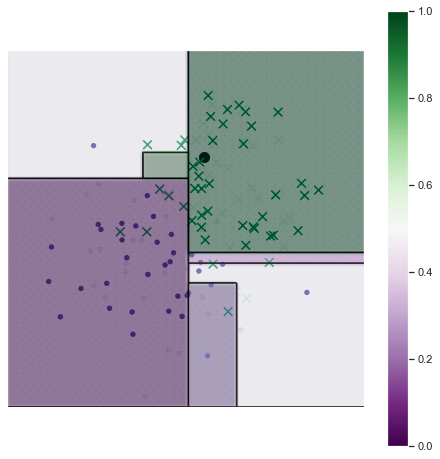

In [28]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[-X_inds2,0], X[-X_inds2,1], c=yX[:len(-X_inds2)], s=75, marker='x')
ax.scatter(Z[-Z_inds2, 0], Z[-Z_inds2, 1], c=yZ[:len(-Z_inds2)], s=75, marker='.')

ax.scatter(X[X_inds2,0], X[X_inds2,1], c=yX[:len(X_inds2)], alpha=0.1, s=75, marker='x')
ax.scatter(Z[Z_inds2, 0], Z[Z_inds2, 1], c=yZ[:len(Z_inds2)], alpha=0.1, s=75, marker='.')

# ax.scatter(X_all[prob_indices, 0], X_all[prob_indices, 1], c=np.concatenate((yX, yZ))[prob_indices], s=50, marker=)
ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border2, s=.5)
ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=posteriors2, alpha=0.0075, cmap='PRGn')

ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

norm = plt.Normalize(0, 1)
cmap = plt.get_cmap("PRGn")
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
ax2 = plt.gca()
cbar = plt.colorbar(sm, ax=ax2)

plt.savefig('decisiontree_for_forest2.png',dpi=500)

In [29]:
# from matplotlib.cm import ScalarMappable

# fig, ax = plt.subplots(1,1,figsize=(8,8))

# ax.scatter(0.5, 2, s=100, c=colors[0], marker='o')

# # ax.scatter(X[-X_inds2,0], X[-X_inds2,1], c=yX[:len(-X_inds2)], s=75, marker='x')
# # ax.scatter(Z[-Z_inds2, 0], Z[-Z_inds2, 1], c=yZ[:len(-Z_inds2)], s=75, marker='.')

# # ax.scatter(X[X_inds2,0], X[X_inds2,1], c=yX[:len(X_inds2)], alpha=0.1, s=75, marker='x')
# # ax.scatter(Z[Z_inds2, 0], Z[Z_inds2, 1], c=yZ[:len(Z_inds2)], alpha=0.1, s=75, marker='.')

# # ax.scatter(X_all[prob_indices, 0], X_all[prob_indices, 1], c=np.concatenate((yX, yZ))[prob_indices], s=50, marker=)
# ax.scatter(mesh_[idx2, 0], mesh_[idx2, 1], c=border2, s=.5)
# ax.scatter(mesh_[idx, 0], mesh_[idx, 1], c=border, s=.5)

# ax1=ax.scatter(mesh_[:, 0], mesh_[:, 1], c=avg_posteriors, alpha=0.0075, cmap='PRGn')

# ax.set_ylim(-lim, lim)
# ax.set_xlim(-lim, lim)
# ax.set_aspect('equal')

# ax.set_yticks([])
# ax.set_xticks([])

# norm = plt.Normalize(0, 1)
# cmap = plt.get_cmap("PRGn")
# sm =  ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# ax2 = plt.gca()
# cbar = plt.colorbar(sm, ax=ax2)

# plt.savefig('averageposterior_for_forest.png',dpi=500)

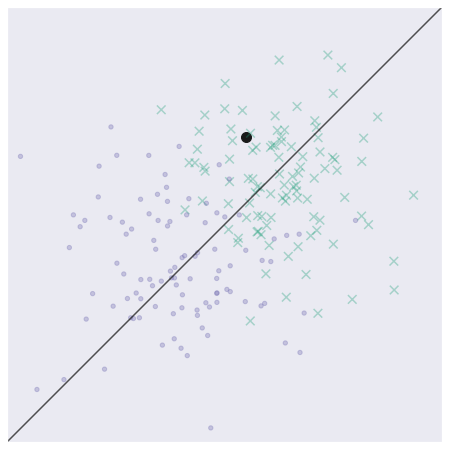

In [5]:
# lim = 4
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='.', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
# ax.scatter(Z[0, 0], Z[0, 1], s=7.5, c=yZ[0])
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.savefig('cml_linear_single_point.png', dpi=500)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-lim, lim +0.05, step=0.05), np.arange(-lim, lim+0.05, step=0.05), c='k', alpha=0.75)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

proj = np.dot(np.array([0.5, 2]), np.array([1, 1])) * np.array([1,1]) / np.dot(np.array([1,1]), np.array([1,1]))

ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

plt.savefig('cml_linear_single_point_projected.png', dpi=500)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c='k', marker='o')

ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-lim, 0 +0.05, step=0.05), np.arange(-lim, 0+0.05, step=0.05), c=colors[2], alpha=1)
ax.plot(np.arange(-0, lim +0.05, step=0.05), np.arange(-0, lim+0.05, step=0.05), c=colors[0], alpha=1)
ax.plot(np.arange(-0.15, 0.2, step=0.025), -np.arange(-0.15, 0.2, step=0.025), c=colors[1], ls=':')
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

proj = np.dot(np.array([0.5, 2]), np.array([1, 1])) * np.array([1,1]) / np.dot(np.array([1,1]), np.array([1,1]))

ax.scatter(proj[0], proj[1], s = 100, marker='*', c='k')

plt.savefig('cml_linear_single_point_decider.png', dpi=500)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(0.5, 2, s=100, c=colors[0], marker='o')

ax.scatter(X[:, 0], X[:, 1], alpha=0.33, s=75, marker='x', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], alpha=0.33, s=75, marker='.', c=yZ)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.plot(np.arange(-lim, 0 +0.05, step=0.05), np.arange(-lim, 0+0.05, step=0.05), c=colors[2], alpha=1)
ax.plot(np.arange(-0, lim +0.05, step=0.05), np.arange(-0, lim+0.05, step=0.05), c=colors[0], alpha=1)
ax.plot(np.arange(-0.15, 0.2, step=0.025), -np.arange(-0.15, 0.2, step=0.025), c=colors[1], ls=':')
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

proj = np.dot(np.array([0.5, 2]), np.array([1, 1])) * np.array([1,1]) / np.dot(np.array([1,1]), np.array([1,1]))

ax.scatter(proj[0], proj[1], s = 100, marker='*', c=colors[0])

plt.savefig('cml_linear_single_point_classified.png', dpi=500)

# figure:
"""
1: All data
2: Structure Data
3: Structure Data + boundaries
4: Estimation Data + boundaries
5: Estimation Data + colored cells
6: Labeled Point
"""

# all data

sns.set()
np.random.seed(1)

yX_ = nx*[0]
yZ_ = nz*[1]


fig, ax = plt.subplots(1,1, figsize=(8,8))
# ax.scatter(0.5, 2, s=100, c='k', marker='o')
ax.scatter(X[:, 0], X[:, 1], s=75, marker='.', c=yX)
ax.scatter(Z[:, 0], Z[:, 1], s=75, marker='.', c=yZ)
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
ax.set_aspect('equal')

ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()

plt.savefig('cml_all_data_nounlabeled.png',dpi=500)